# Fig. 3 - Bifurcation diagram with respect to $e$

Here we compute the bifurcation diagrams with respect to $e$ variable.

In [1]:
%matplotlib inline

from functools import partial
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import ZeroInput

from hippocampus import HippocampalCA3Node
from utils import run_in_parallel

plt.style.use("default_light")

## Helper function
- `compute_wrt_e`: computes steady state solution of the model for a given value of $e$ for two initial conditions: one is starting in the SWR state, while the second one is starting in the non-SWR state; computation is done with both backends available in the `MultiModel` framework of `neurolib`

In [2]:
def compute_wrt_e(e, backend="numba"):
    results = []
    for init_c in [0, 1]:
        hc = HippocampalCA3Node(constant_depression=True)
        for mass in hc:
            mass._noise_input = [ZeroInput()]
        m = MultiModel.init_node(hc)
        if init_c == 0:
            # SWR state
            m.model_instance.initial_state = np.array([0.044, 0.092, 0.0])
        else:
            # non-SWR state
            m.model_instance.initial_state = np.array([0.0, 0.0, 0.0125])
        m.params["backend"] = backend
        m.params["duration"] = 2000
        m.params["sampling_dt"] = 1.0
        m.params["dt"] = 0.05
        m.params["*aSWR*e|noise"] = e
        m.run()
        arr = xr.DataArray(
            np.array(
                [
                    float(m.r_mean_EXC.T[-1]),
                    float(m.r_mean_INH.T[-1]),
                    float(m.r_mean_aSWR.T[-1]),
                ]
            ),
            dims=["node"],
            coords={"node": ["P", "B", "A"]},
        ).assign_coords({"e": e, "init_c": init_c})
        results.append(arr)

    return results

## Compute

Compute steady state solutions in parallel and stack them using `xr.DataArray`

In [3]:
es = np.linspace(0.0, 1.0, 151)

res = run_in_parallel(
    partial(compute_wrt_e, backend="numba"), es, workers=6
)

bif_wrt_e = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["e", "init_c"])
    .unstack("new")
)

100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


## Plot

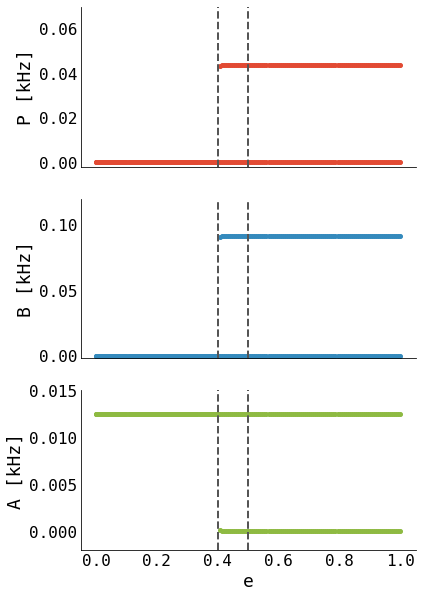

In [4]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(6, 10), sharex=True)
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for i, var in enumerate(bif_wrt_e["node"]):
    axs[i].plot(
        es, bif_wrt_e.sel({"node": var}).values, "o", color=colors[i], markersize=4
    )
    axs[i].set_ylim([-0.002, maxs[i]])
    axs[i].set_ylabel(f"{var.values} [kHz]")
    axs[i].axvline(0.4, linestyle="--", color="#555555")
    axs[i].axvline(0.5, linestyle="--", color="#555555")
    sns.despine(ax=axs[i])
axs[-1].set_xlabel("e")
plt.savefig("../figs/bifurcation_wrt_e.pdf", transparent=True, bbox_inches="tight")

## Repeat for `jitcdde` backend

In [5]:
es = np.linspace(0.0, 1.0, 151)

res = run_in_parallel(
    partial(compute_wrt_e, backend="jitcdde"), es, workers=6
)

bif_wrt_e = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["e", "init_c"])
    .unstack("new")
)

  0%|          | 0/151 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input pas

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 232751.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 234024.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 212968.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 165289.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 142184.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 155157.

Using default integration parameters.


  1%|          | 1/151 [00:03<08:09,  3.26s/it]

Using default integration parameters.


  1%|▏         | 2/151 [00:03<03:31,  1.42s/it]

Using default integration parameters.


  2%|▏         | 3/151 [00:03<02:13,  1.11it/s]

Using default integration parameters.


  3%|▎         | 4/151 [00:03<01:31,  1.61it/s]

Using default integration parameters.


  3%|▎         | 5/151 [00:04<01:10,  2.08it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196041.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130270.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249505.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203237.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 230039.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157606.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265009.41it/s]


Using default integration parameters.


  5%|▍         | 7/151 [00:05<01:29,  1.61it/s]

Using default integration parameters.


  5%|▌         | 8/151 [00:05<01:10,  2.02it/s]

Using default integration parameters.


  6%|▌         | 9/151 [00:05<00:58,  2.42it/s]

Using default integration parameters.


  7%|▋         | 10/151 [00:06<00:47,  2.98it/s]

Using default integration parameters.


  7%|▋         | 11/151 [00:06<00:40,  3.50it/s]

Using default integration parameters.


  8%|▊         | 12/151 [00:06<00:34,  4.02it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252334.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223636.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206682.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216782.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170559.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140221.45it/s]


Using default integration parameters.


  9%|▊         | 13/151 [00:07<01:27,  1.57it/s]

Using default integration parameters.


  9%|▉         | 14/151 [00:08<01:08,  1.99it/s]

Using default integration parameters.


 10%|▉         | 15/151 [00:08<00:56,  2.41it/s]

Using default integration parameters.


 11%|█         | 16/151 [00:08<00:48,  2.81it/s]

Using default integration parameters.


 11%|█▏        | 17/151 [00:08<00:42,  3.19it/s]

Using default integration parameters.


 12%|█▏        | 18/151 [00:09<00:37,  3.50it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145998.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219281.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153269.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205401.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157145.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188448.76it/s]


Using default integration parameters.


 13%|█▎        | 19/151 [00:10<01:31,  1.44it/s]

Using default integration parameters.


 13%|█▎        | 20/151 [00:10<01:14,  1.75it/s]

Using default integration parameters.


 14%|█▍        | 21/151 [00:11<00:58,  2.22it/s]

Using default integration parameters.


 15%|█▍        | 22/151 [00:11<00:50,  2.56it/s]

Using default integration parameters.


 15%|█▌        | 23/151 [00:11<00:41,  3.06it/s]

Using default integration parameters.


 16%|█▌        | 24/151 [00:11<00:34,  3.67it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121766.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112429.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132844.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259982.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131002.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113443.88it/s]


Using default integration parameters.


 17%|█▋        | 25/151 [00:13<01:30,  1.39it/s]

Using default integration parameters.


 17%|█▋        | 26/151 [00:13<01:21,  1.54it/s]

Using default integration parameters.


 18%|█▊        | 27/151 [00:14<01:03,  1.95it/s]

Using default integration parameters.


 19%|█▊        | 28/151 [00:14<00:55,  2.21it/s]

Using default integration parameters.


 19%|█▉        | 29/151 [00:14<00:43,  2.80it/s]

Using default integration parameters.


 20%|█▉        | 30/151 [00:14<00:40,  3.01it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150206.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126239.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150406.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143933.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188093.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213087.31it/s]


Using default integration parameters.


 21%|██        | 31/151 [00:16<01:25,  1.41it/s]

Using default integration parameters.


 21%|██        | 32/151 [00:16<01:09,  1.72it/s]

Using default integration parameters.


 22%|██▏       | 33/151 [00:16<00:53,  2.20it/s]

Using default integration parameters.


 23%|██▎       | 34/151 [00:17<00:48,  2.39it/s]

Using default integration parameters.


 23%|██▎       | 35/151 [00:17<00:40,  2.85it/s]

Using default integration parameters.


 24%|██▍       | 36/151 [00:17<00:38,  2.98it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 99305.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256870.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193032.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141843.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127756.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186062.06it/s]


Using default integration parameters.


 25%|██▍       | 37/151 [00:19<01:17,  1.47it/s]

Using default integration parameters.


 25%|██▌       | 38/151 [00:19<01:00,  1.87it/s]

Using default integration parameters.


 26%|██▌       | 39/151 [00:19<00:45,  2.44it/s]

Using default integration parameters.


 26%|██▋       | 40/151 [00:19<00:41,  2.69it/s]

Using default integration parameters.


 27%|██▋       | 41/151 [00:20<00:35,  3.12it/s]

Using default integration parameters.


 28%|██▊       | 42/151 [00:20<00:30,  3.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93611.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250189.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210151.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139626.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253065.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 183297.45it/s]


Using default integration parameters.


 28%|██▊       | 43/151 [00:21<01:05,  1.64it/s]

Using default integration parameters.


 29%|██▉       | 44/151 [00:21<00:50,  2.11it/s]

Using default integration parameters.


 30%|██▉       | 45/151 [00:21<00:40,  2.62it/s]

Using default integration parameters.


 30%|███       | 46/151 [00:22<00:33,  3.16it/s]

Using default integration parameters.


 31%|███       | 47/151 [00:22<00:29,  3.51it/s]

Using default integration parameters.


 32%|███▏      | 48/151 [00:22<00:31,  3.31it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 146995.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148974.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162089.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253424.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250062.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253677.51it/s]


Using default integration parameters.


 32%|███▏      | 49/151 [00:24<01:13,  1.39it/s]

Using default integration parameters.


 33%|███▎      | 50/151 [00:24<00:55,  1.81it/s]

Using default integration parameters.


 34%|███▍      | 51/151 [00:24<00:44,  2.23it/s]

Using default integration parameters.


 34%|███▍      | 52/151 [00:24<00:35,  2.82it/s]

Using default integration parameters.


 35%|███▌      | 53/151 [00:25<00:31,  3.14it/s]

Using default integration parameters.


 36%|███▌      | 54/151 [00:25<00:27,  3.58it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167053.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254841.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233809.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137259.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265857.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144653.62it/s]


Using default integration parameters.


 36%|███▋      | 55/151 [00:26<00:53,  1.78it/s]

Using default integration parameters.


 37%|███▋      | 56/151 [00:26<00:42,  2.25it/s]

Using default integration parameters.


 38%|███▊      | 57/151 [00:26<00:34,  2.69it/s]

Using default integration parameters.


 38%|███▊      | 58/151 [00:27<00:29,  3.10it/s]

Using default integration parameters.


 39%|███▉      | 59/151 [00:27<00:24,  3.72it/s]

Using default integration parameters.


 40%|███▉      | 60/151 [00:27<00:22,  4.10it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135180.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155111.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132836.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259355.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170864.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 78401.14it/s]


Using default integration parameters.


 40%|████      | 61/151 [00:28<00:55,  1.63it/s]

Using default integration parameters.


 41%|████      | 62/151 [00:28<00:41,  2.13it/s]

Using default integration parameters.


 42%|████▏     | 63/151 [00:29<00:38,  2.31it/s]

Using default integration parameters.


 42%|████▏     | 64/151 [00:29<00:32,  2.70it/s]

Using default integration parameters.


 43%|████▎     | 65/151 [00:29<00:27,  3.17it/s]

Using default integration parameters.


 44%|████▎     | 66/151 [00:30<00:27,  3.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117349.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121140.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225736.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260629.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 237160.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192899.21it/s]


Using default integration parameters.


 44%|████▍     | 67/151 [00:31<00:51,  1.64it/s]

Using default integration parameters.


 45%|████▌     | 68/151 [00:31<00:41,  2.01it/s]

Using default integration parameters.


 46%|████▌     | 69/151 [00:31<00:32,  2.50it/s]

Using default integration parameters.


 46%|████▋     | 70/151 [00:31<00:26,  3.05it/s]

Using default integration parameters.


 47%|████▋     | 71/151 [00:32<00:22,  3.56it/s]

Using default integration parameters.


 48%|████▊     | 72/151 [00:32<00:22,  3.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 118793.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 232506.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204965.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 163081.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222598.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 120735.88it/s]


Using default integration parameters.


 48%|████▊     | 73/151 [00:33<00:48,  1.60it/s]

Using default integration parameters.


 49%|████▉     | 74/151 [00:33<00:37,  2.04it/s]

Using default integration parameters.


 50%|████▉     | 75/151 [00:34<00:35,  2.15it/s]

Using default integration parameters.


 50%|█████     | 76/151 [00:34<00:26,  2.78it/s]

Using default integration parameters.


 51%|█████     | 77/151 [00:34<00:23,  3.17it/s]

Using default integration parameters.


 52%|█████▏    | 78/151 [00:34<00:21,  3.35it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 86464.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 169507.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170368.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225276.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249690.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213700.72it/s]


Using default integration parameters.


 52%|█████▏    | 79/151 [00:36<00:48,  1.50it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253708.20it/s]


Using default integration parameters.


 54%|█████▎    | 81/151 [00:36<00:31,  2.21it/s]

Using default integration parameters.


 54%|█████▍    | 82/151 [00:37<00:26,  2.57it/s]

Using default integration parameters.


 55%|█████▍    | 83/151 [00:37<00:21,  3.11it/s]

Using default integration parameters.


 56%|█████▌    | 84/151 [00:37<00:20,  3.35it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193161.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160954.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193085.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251095.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196961.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256767.92it/s]


Using default integration parameters.


 56%|█████▋    | 85/151 [00:38<00:39,  1.67it/s]

Using default integration parameters.


 57%|█████▋    | 86/151 [00:39<00:32,  2.00it/s]

Using default integration parameters.


 58%|█████▊    | 87/151 [00:39<00:26,  2.44it/s]

Using default integration parameters.


 58%|█████▊    | 88/151 [00:39<00:21,  2.88it/s]

Using default integration parameters.


 59%|█████▉    | 89/151 [00:39<00:17,  3.45it/s]

Using default integration parameters.


 60%|█████▉    | 90/151 [00:39<00:18,  3.21it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164786.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222651.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258540.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180322.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157243.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 169957.82it/s]


Using default integration parameters.


 60%|██████    | 91/151 [00:41<00:35,  1.69it/s]

Using default integration parameters.


 61%|██████    | 92/151 [00:41<00:29,  1.98it/s]

Using default integration parameters.


 62%|██████▏   | 93/151 [00:41<00:22,  2.53it/s]

Using default integration parameters.


 62%|██████▏   | 94/151 [00:41<00:18,  3.02it/s]

Using default integration parameters.


 63%|██████▎   | 95/151 [00:41<00:15,  3.73it/s]

Using default integration parameters.


 64%|██████▎   | 96/151 [00:42<00:14,  3.73it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 232313.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188039.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208009.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180929.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161158.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170579.91it/s]


Using default integration parameters.


 64%|██████▍   | 97/151 [00:43<00:32,  1.69it/s]

Using default integration parameters.


 65%|██████▍   | 98/151 [00:43<00:26,  1.99it/s]

Using default integration parameters.


 66%|██████▌   | 99/151 [00:44<00:21,  2.44it/s]

Using default integration parameters.


 66%|██████▌   | 100/151 [00:44<00:17,  2.85it/s]

Using default integration parameters.


 67%|██████▋   | 101/151 [00:44<00:14,  3.47it/s]

Using default integration parameters.


 68%|██████▊   | 102/151 [00:44<00:12,  3.96it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164083.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134934.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259003.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190455.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 267093.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221288.59it/s]


Using default integration parameters.


 68%|██████▊   | 103/151 [00:45<00:26,  1.79it/s]

Using default integration parameters.


 69%|██████▉   | 104/151 [00:46<00:20,  2.27it/s]

Using default integration parameters.


 70%|██████▉   | 105/151 [00:46<00:16,  2.80it/s]

Using default integration parameters.


 70%|███████   | 106/151 [00:46<00:13,  3.26it/s]

Using default integration parameters.


 71%|███████   | 107/151 [00:46<00:11,  3.73it/s]

Using default integration parameters.


 72%|███████▏  | 108/151 [00:46<00:10,  4.01it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 234790.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 243897.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138879.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172786.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135850.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210573.29it/s]


Using default integration parameters.


 72%|███████▏  | 109/151 [00:48<00:23,  1.76it/s]

Using default integration parameters.


 73%|███████▎  | 110/151 [00:48<00:18,  2.24it/s]

Using default integration parameters.


 74%|███████▎  | 111/151 [00:48<00:14,  2.77it/s]

Using default integration parameters.


 74%|███████▍  | 112/151 [00:48<00:12,  3.16it/s]

Using default integration parameters.


 75%|███████▍  | 113/151 [00:48<00:10,  3.65it/s]

Using default integration parameters.


 75%|███████▌  | 114/151 [00:49<00:09,  3.85it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227685.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223160.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134780.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127982.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 273111.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235900.11it/s]


Using default integration parameters.


 76%|███████▌  | 115/151 [00:50<00:20,  1.76it/s]

Using default integration parameters.


 77%|███████▋  | 116/151 [00:50<00:15,  2.29it/s]

Using default integration parameters.


 77%|███████▋  | 117/151 [00:50<00:12,  2.80it/s]

Using default integration parameters.


 78%|███████▊  | 118/151 [00:50<00:10,  3.23it/s]

Using default integration parameters.


 79%|███████▉  | 119/151 [00:50<00:08,  3.77it/s]

Using default integration parameters.


 79%|███████▉  | 120/151 [00:51<00:08,  3.81it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220040.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 271002.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150430.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127208.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155410.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 120192.68it/s]


Using default integration parameters.


 80%|████████  | 121/151 [00:52<00:17,  1.70it/s]

Using default integration parameters.


 81%|████████  | 122/151 [00:52<00:13,  2.20it/s]

Using default integration parameters.


 81%|████████▏ | 123/151 [00:52<00:10,  2.57it/s]

Using default integration parameters.


 82%|████████▏ | 124/151 [00:53<00:09,  2.96it/s]

Using default integration parameters.


 83%|████████▎ | 125/151 [00:53<00:07,  3.49it/s]

Using default integration parameters.


 83%|████████▎ | 126/151 [00:53<00:06,  3.81it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174519.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263883.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161316.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132571.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261433.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257374.53it/s]


Using default integration parameters.


 84%|████████▍ | 127/151 [00:54<00:13,  1.76it/s]

Using default integration parameters.


 85%|████████▍ | 128/151 [00:55<00:10,  2.24it/s]

Using default integration parameters.


 85%|████████▌ | 129/151 [00:55<00:07,  2.81it/s]

Using default integration parameters.


 86%|████████▌ | 130/151 [00:55<00:06,  3.38it/s]

Using default integration parameters.


 87%|████████▋ | 131/151 [00:55<00:05,  3.45it/s]

Using default integration parameters.


 87%|████████▋ | 132/151 [00:55<00:04,  4.12it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 267442.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213668.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175640.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135748.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158314.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 183053.46it/s]


Using default integration parameters.


 88%|████████▊ | 133/151 [00:57<00:11,  1.54it/s]

Using default integration parameters.


 89%|████████▊ | 134/151 [00:57<00:08,  2.00it/s]

Using default integration parameters.


 89%|████████▉ | 135/151 [00:57<00:06,  2.41it/s]

Using default integration parameters.


 90%|█████████ | 136/151 [00:57<00:05,  2.83it/s]

Using default integration parameters.


 91%|█████████ | 137/151 [00:58<00:04,  3.33it/s]

Using default integration parameters.


 91%|█████████▏| 138/151 [00:58<00:03,  3.95it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259436.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209757.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210156.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201998.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176201.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 168747.52it/s]


Using default integration parameters.


 92%|█████████▏| 139/151 [00:59<00:08,  1.49it/s]

Using default integration parameters.


 93%|█████████▎| 140/151 [01:00<00:06,  1.69it/s]

Using default integration parameters.


 93%|█████████▎| 141/151 [01:00<00:04,  2.19it/s]

Using default integration parameters.


 94%|█████████▍| 142/151 [01:00<00:03,  2.70it/s]

Using default integration parameters.


 95%|█████████▍| 143/151 [01:00<00:02,  2.97it/s]

Using default integration parameters.


 95%|█████████▌| 144/151 [01:00<00:01,  3.56it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261270.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143204.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144320.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252016.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223815.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137922.89it/s]


Using default integration parameters.


 96%|█████████▌| 145/151 [01:02<00:03,  1.70it/s]

Using default integration parameters.


 97%|█████████▋| 146/151 [01:02<00:02,  2.15it/s]

Using default integration parameters.


 97%|█████████▋| 147/151 [01:02<00:01,  2.71it/s]

Using default integration parameters.


 98%|█████████▊| 148/151 [01:02<00:00,  3.32it/s]

Using default integration parameters.


 99%|█████████▊| 149/151 [01:02<00:00,  3.88it/s]

Using default integration parameters.


 99%|█████████▉| 150/151 [01:03<00:00,  4.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 271880.73it/s]


Using default integration parameters.


100%|██████████| 151/151 [01:04<00:00,  2.34it/s]


Text(0.5, 0, 'e')

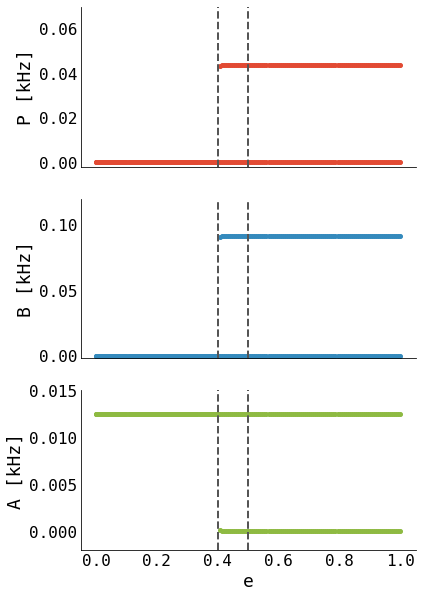

In [6]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(6, 10), sharex=True)
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for i, var in enumerate(bif_wrt_e["node"]):
    axs[i].plot(
        es, bif_wrt_e.sel({"node": var}).values, "o", color=colors[i], markersize=4
    )
    axs[i].set_ylim([-0.002, maxs[i]])
    axs[i].set_ylabel(f"{var.values} [kHz]")
    axs[i].axvline(0.4, linestyle="--", color="#555555")
    axs[i].axvline(0.5, linestyle="--", color="#555555")
    sns.despine(ax=axs[i])
axs[-1].set_xlabel("e")

## Profit

We got same figures, all good.